In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [ ]:
!pip install yfinance


In [ ]:
import yfinance as yf

stocks = ["NMDC.NS", "NHPC.NS", "IOB.NS", "CASTROLIND.NS", "ASHOKLEY.NS"]

stock_data = {}

# 5 years of data from selected stocks
for stock in stocks:
    data = yf.download(stock, start="2019-01-01", end="2024-12-31")
    stock_data[stock] = data
    print(f"✅ Data fetched for {stock} | Rows: {data.shape[0]}")

stock_data[stocks[0]].head()


/tmp/ipython-input-4050359886.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(stock, start="2019-01-01", end="2024-12-31")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-4050359886.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(stock, start="2019-01-01", end="2024-12-31")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-4050359886.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(stock, start="2019-01-01", end="2024-12-31")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-4050359886.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(stock, start="2019-01-01", end="2024-12-31")
[*********************100%***********************]  1 of 1 completed
/tmp

✅ Data fetched for NMDC.NS | Rows: 1480
✅ Data fetched for NHPC.NS | Rows: 1480
✅ Data fetched for IOB.NS | Rows: 1480
✅ Data fetched for CASTROLIND.NS | Rows: 1480
✅ Data fetched for ASHOKLEY.NS | Rows: 1480


Price,Close,High,Low,Open,Volume
Ticker,NMDC.NS,NMDC.NS,NMDC.NS,NMDC.NS,NMDC.NS
Date,,,,,
2019-01-01,15.191619,15.453406,15.104356,15.374076,4938201
2019-01-02,15.358211,15.786589,15.334411,15.548602,51139813
2019-01-03,14.898101,15.453407,14.866368,15.437542,24553663
2019-01-04,14.906029,15.072620,14.755302,14.913961,18471134
2019-01-07,15.064691,15.207484,14.929830,15.072623,13244881


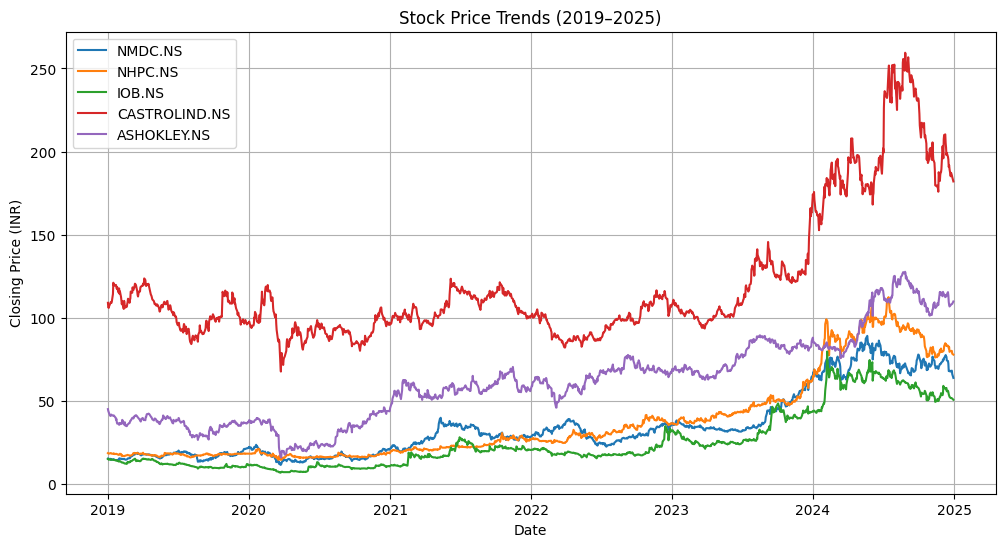

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

for stock in stocks:
    plt.plot(stock_data[stock]['Close'], label=stock)

plt.title("Stock Price Trends (2019–2025)")
plt.xlabel("Date")
plt.ylabel("Closing Price (INR)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

stock = "NMDC.NS"
df = stock_data[stock]

close_prices = df['Close'].values.reshape(-1,1)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(close_prices)

sequence_length = 60  # last 60 days
X = []
y = []

for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i, 0])
    y.append(scaled_data[i, 0])


X, y = np.array(X), np.array(y)

X = np.reshape(X, (X.shape[0], X.shape[1], 1))

train_size = int(0.8 * X.shape[0])
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])


Training samples: 1136
Testing samples: 284


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model_nmdc = Sequential()

model_nmdc.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_nmdc.add(Dropout(0.2))  # Prevent overfitting

model_nmdc.add(LSTM(units=50, return_sequences=False))
model_nmdc.add(Dropout(0.2))

model_nmdc.add(Dense(1))  # Predict next day price

model_nmdc.compile(optimizer='adam', loss='mean_squared_error')

model_nmdc.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train NMDC model
history_nmdc = model_nmdc.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))



Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - loss: 0.0159 - val_loss: 0.0046
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0011 - val_loss: 0.0025
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 7.7609e-04 - val_loss: 0.0025
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 8.0739e-04 - val_loss: 0.0035
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 6.9786e-04 - val_loss: 0.0025
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 6.6981e-04 - val_loss: 0.0029
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 6.5135e-04 - val_loss: 0.0032
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 8.1182e-04 - val_loss: 0.0034
Epoch 9/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 6.5104e-04 - val_loss: 0.0019
Epoch 10/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 6.3121e-04 - val_loss: 0.0020
Epoch 11/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 5.2176e-04 - val_loss: 0.0019
Epoch 12/50
36/36 ━━━━━━━━━

In [ ]:
stock = "NHPC.NS"
df_nhpc = stock_data[stock]

close_prices_nhpc = df_nhpc['Close'].values.reshape(-1,1)

scaler_nhpc = MinMaxScaler(feature_range=(0,1))
scaled_data_nhpc = scaler_nhpc.fit_transform(close_prices_nhpc)

sequence_length = 60
X_nhpc = []
y_nhpc = []

for i in range(sequence_length, len(scaled_data_nhpc)):
    X_nhpc.append(scaled_data_nhpc[i-sequence_length:i, 0])
    y_nhpc.append(scaled_data_nhpc[i, 0])

X_nhpc, y_nhpc = np.array(X_nhpc), np.array(y_nhpc)
X_nhpc = np.reshape(X_nhpc, (X_nhpc.shape[0], X_nhpc.shape[1], 1))

train_size = int(0.8 * X_nhpc.shape[0])
X_train_nhpc, X_test_nhpc = X_nhpc[:train_size], X_nhpc[train_size:]
y_train_nhpc, y_test_nhpc = y_nhpc[:train_size], y_nhpc[train_size:]

print("NHPC - Training samples:", X_train_nhpc.shape[0])
print("NHPC - Testing samples:", X_test_nhpc.shape[0])


NHPC - Training samples: 1136
NHPC - Testing samples: 284


In [ ]:
model_nhpc = Sequential()

model_nhpc.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_nhpc.shape[1],1)))
model_nhpc.add(Dropout(0.2))

model_nhpc.add(LSTM(units=50, return_sequences=False))
model_nhpc.add(Dropout(0.2))

model_nhpc.add(Dense(1))

model_nhpc.compile(optimizer='adam', loss='mean_squared_error')
model_nhpc.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_nhpc = model_nhpc.fit(X_train_nhpc, y_train_nhpc, epochs=50, batch_size=32, validation_data=(X_test_nhpc, y_test_nhpc))


Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.0099 - val_loss: 0.0035
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 5.0579e-04 - val_loss: 0.0034
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 4.8924e-04 - val_loss: 0.0033
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 3.8596e-04 - val_loss: 0.0026
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 3.6610e-04 - val_loss: 0.0054
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 3.5931e-04 - val_loss: 0.0029
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 3.1642e-04 - val_loss: 0.0042
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 3.1662e-04 - val_loss: 0.0034
Epoch 9/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 2.7612e-04 - val_loss: 0.0054
Epoch 10/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 3.2224e-04 - val_loss: 0.0038
Epoch 11/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 2.2919e-04 - val_loss: 0.0058
Epoch 12/50
36/36 ━━━━━

In [ ]:
stock = "IOB.NS"
df_iob = stock_data[stock]

close_prices_iob = df_iob['Close'].values.reshape(-1,1)

scaler_iob = MinMaxScaler(feature_range=(0,1))
scaled_data_iob = scaler_iob.fit_transform(close_prices_iob)

sequence_length = 60
X_iob = []
y_iob = []

for i in range(sequence_length, len(scaled_data_iob)):
    X_iob.append(scaled_data_iob[i-sequence_length:i, 0])
    y_iob.append(scaled_data_iob[i, 0])

X_iob, y_iob = np.array(X_iob), np.array(y_iob)
X_iob = np.reshape(X_iob, (X_iob.shape[0], X_iob.shape[1], 1))

train_size = int(0.8 * X_iob.shape[0])
X_train_iob, X_test_iob = X_iob[:train_size], X_iob[train_size:]
y_train_iob, y_test_iob = y_iob[:train_size], y_iob[train_size:]

print("IOB - Training samples:", X_train_iob.shape[0])
print("IOB - Testing samples:", X_test_iob.shape[0])


IOB - Training samples: 1136
IOB - Testing samples: 284


In [ ]:
model_iob = Sequential()

model_iob.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_iob.shape[1],1)))
model_iob.add(Dropout(0.2))

model_iob.add(LSTM(units=50, return_sequences=False))
model_iob.add(Dropout(0.2))

model_iob.add(Dense(1))

model_iob.compile(optimizer='adam', loss='mean_squared_error')
model_iob.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_iob = model_iob.fit(X_train_iob, y_train_iob, epochs=50, batch_size=32, validation_data=(X_test_iob, y_test_iob))


Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 0.0152 - val_loss: 0.0043
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 8.1491e-04 - val_loss: 0.0033
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 6.6980e-04 - val_loss: 0.0038
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 7.9385e-04 - val_loss: 0.0032
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 6.1142e-04 - val_loss: 0.0028
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 5.6487e-04 - val_loss: 0.0041
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 5.5036e-04 - val_loss: 0.0026
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 6.4062e-04 - val_loss: 0.0032
Epoch 9/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 5.2731e-04 - val_loss: 0.0028
Epoch 10/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 5.4762e-04 - val_loss: 0.0046
Epoch 11/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 5.7573e-04 - val_loss: 0.0031
Epoch 12/50
36/36 ━━━━━

In [ ]:
stock = "CASTROLIND.NS"
df_castrol = stock_data[stock]

close_prices_castrol = df_castrol['Close'].values.reshape(-1,1)

scaler_castrol = MinMaxScaler(feature_range=(0,1))
scaled_data_castrol = scaler_castrol.fit_transform(close_prices_castrol)

sequence_length = 60
X_castrol = []
y_castrol = []

for i in range(sequence_length, len(scaled_data_castrol)):
    X_castrol.append(scaled_data_castrol[i-sequence_length:i, 0])
    y_castrol.append(scaled_data_castrol[i, 0])

X_castrol, y_castrol = np.array(X_castrol), np.array(y_castrol)
X_castrol = np.reshape(X_castrol, (X_castrol.shape[0], X_castrol.shape[1], 1))

train_size = int(0.8 * X_castrol.shape[0])
X_train_castrol, X_test_castrol = X_castrol[:train_size], X_castrol[train_size:]
y_train_castrol, y_test_castrol = y_castrol[:train_size], y_castrol[train_size:]

print("Castrol - Training samples:", X_train_castrol.shape[0])
print("Castrol - Testing samples:", X_test_castrol.shape[0])


Castrol - Training samples: 1136
Castrol - Testing samples: 284


In [ ]:
model_castrol = Sequential()

model_castrol.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_castrol.shape[1],1)))
model_castrol.add(Dropout(0.2))

model_castrol.add(LSTM(units=50, return_sequences=False))
model_castrol.add(Dropout(0.2))

model_castrol.add(Dense(1))

model_castrol.compile(optimizer='adam', loss='mean_squared_error')
model_castrol.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_castrol = model_castrol.fit(X_train_castrol, y_train_castrol, epochs=50, batch_size=32, validation_data=(X_test_castrol, y_test_castrol))


Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 0.0111 - val_loss: 0.0392
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0013 - val_loss: 0.0061
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 8.7994e-04 - val_loss: 0.0052
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 7.5819e-04 - val_loss: 0.0036
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 7.1628e-04 - val_loss: 0.0035
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 6.6952e-04 - val_loss: 0.0034
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 6.6400e-04 - val_loss: 0.0030
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 5.9406e-04 - val_loss: 0.0028
Epoch 9/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 5.5206e-04 - val_loss: 0.0027
Epoch 10/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 5.3883e-04 - val_loss: 0.0028
Epoch 11/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 4.8549e-04 - val_loss: 0.0031
Epoch 12/50
36/36 ━━━━━━━━━

In [ ]:
stock = "ASHOKLEY.NS"
df_ashok = stock_data[stock]

close_prices_ashok = df_ashok['Close'].values.reshape(-1,1)

scaler_ashok = MinMaxScaler(feature_range=(0,1))
scaled_data_ashok = scaler_ashok.fit_transform(close_prices_ashok)

sequence_length = 60
X_ashok = []
y_ashok = []

for i in range(sequence_length, len(scaled_data_ashok)):
    X_ashok.append(scaled_data_ashok[i-sequence_length:i, 0])
    y_ashok.append(scaled_data_ashok[i, 0])

X_ashok, y_ashok = np.array(X_ashok), np.array(y_ashok)
X_ashok = np.reshape(X_ashok, (X_ashok.shape[0], X_ashok.shape[1], 1))

train_size = int(0.8 * X_ashok.shape[0])
X_train_ashok, X_test_ashok = X_ashok[:train_size], X_ashok[train_size:]
y_train_ashok, y_test_ashok = y_ashok[:train_size], y_ashok[train_size:]

print("Ashok Leyland - Training samples:", X_train_ashok.shape[0])
print("Ashok Leyland - Testing samples:", X_test_ashok.shape[0])


Ashok Leyland - Training samples: 1136
Ashok Leyland - Testing samples: 284


In [ ]:
model_ashok = Sequential()

model_ashok.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_ashok.shape[1],1)))
model_ashok.add(Dropout(0.2))

model_ashok.add(LSTM(units=50, return_sequences=False))
model_ashok.add(Dropout(0.2))

model_ashok.add(Dense(1))

model_ashok.compile(optimizer='adam', loss='mean_squared_error')
model_ashok.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_ashok = model_ashok.fit(X_train_ashok, y_train_ashok, epochs=50, batch_size=32, validation_data=(X_test_ashok, y_test_ashok))


Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 0.0340 - val_loss: 0.0137
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0028 - val_loss: 0.0020
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0020 - val_loss: 0.0017
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0020 - val_loss: 0.0029
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0020 - val_loss: 0.0028
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0017 - val_loss: 0.0013
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0016 - val_loss: 0.0023
Epoch 9/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 10/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 11/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0015 - val_loss: 0.0034
Epoch 12/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0

/tmp/ipython-input-2483681860.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_nmdc = yf.download("NMDC.NS", start="2018-01-01", end="2025-01-01")
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.0093 - val_loss: 0.0034
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 6.9828e-04 - val_loss: 0.0033
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 5.6471e-04 - val_loss: 0.0022
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 5.1281e-04 - val_loss: 0.0021
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 5.4344e-04 - val_loss: 0.0024
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 5.7758e-04 - val_loss: 0.0025
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 5.0552e-04 - val_loss: 0.0025
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 3.8978e-04 - val_loss: 0.0022
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 4.8369e-04 - val_loss: 0.0047
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 4.1525e-04 - val_loss: 0.0058
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


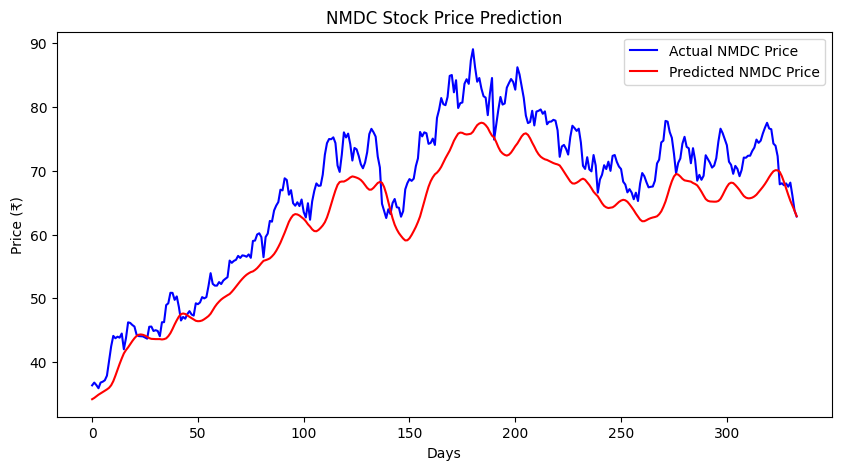

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

import yfinance as yf

df_nmdc = yf.download("NMDC.NS", start="2018-01-01", end="2025-01-01")

close_prices_nmdc = df_nmdc['Close'].values.reshape(-1,1)
scaler_nmdc = MinMaxScaler(feature_range=(0,1))
scaled_data_nmdc = scaler_nmdc.fit_transform(close_prices_nmdc)

sequence_length = 60
X_nmdc, y_nmdc = [], []

for i in range(sequence_length, len(scaled_data_nmdc)):
    X_nmdc.append(scaled_data_nmdc[i-sequence_length:i, 0])
    y_nmdc.append(scaled_data_nmdc[i, 0])

X_nmdc, y_nmdc = np.array(X_nmdc), np.array(y_nmdc)
X_nmdc = np.reshape(X_nmdc, (X_nmdc.shape[0], X_nmdc.shape[1], 1))

train_size = int(0.8 * X_nmdc.shape[0])
X_train_nmdc, X_test_nmdc = X_nmdc[:train_size], X_nmdc[train_size:]
y_train_nmdc, y_test_nmdc = y_nmdc[:train_size], y_nmdc[train_size:]

model_nmdc = Sequential()
model_nmdc.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_nmdc.shape[1],1)))
model_nmdc.add(Dropout(0.2))
model_nmdc.add(LSTM(units=50, return_sequences=False))
model_nmdc.add(Dropout(0.2))
model_nmdc.add(Dense(1))
model_nmdc.compile(optimizer='adam', loss='mean_squared_error')

model_nmdc.fit(X_train_nmdc, y_train_nmdc, epochs=10, batch_size=32, validation_data=(X_test_nmdc, y_test_nmdc), verbose=1)

predicted_prices_nmdc = model_nmdc.predict(X_test_nmdc)
predicted_prices_nmdc = scaler_nmdc.inverse_transform(predicted_prices_nmdc.reshape(-1, 1))
real_prices_nmdc = scaler_nmdc.inverse_transform(y_test_nmdc.reshape(-1, 1))

plt.figure(figsize=(10,5))
plt.plot(real_prices_nmdc, color='blue', label='Actual NMDC Price')
plt.plot(predicted_prices_nmdc, color='red', label='Predicted NMDC Price')
plt.title('NMDC Stock Price Prediction')
plt.xlabel('Days')
plt.ylabel('Price (₹)')
plt.legend()
plt.show()


/tmp/ipython-input-1563114545.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_nhpc = yf.download("NHPC.NS", start="2018-01-01", end="2025-01-01")
[*********************100%***********************]  1 of 1 completed

Epoch 1/10



/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.0071 - val_loss: 0.0041
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 3.4508e-04 - val_loss: 0.0097
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 2.6911e-04 - val_loss: 0.0035
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 2.3479e-04 - val_loss: 0.0025
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 2.9198e-04 - val_loss: 0.0054
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 2.6657e-04 - val_loss: 0.0026
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 2.2734e-04 - val_loss: 0.0021
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 2.2541e-04 - val_loss: 0.0020
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 2.4906e-04 - val_loss: 0.0023
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 2.1761e-04 - val_loss: 0.0021
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


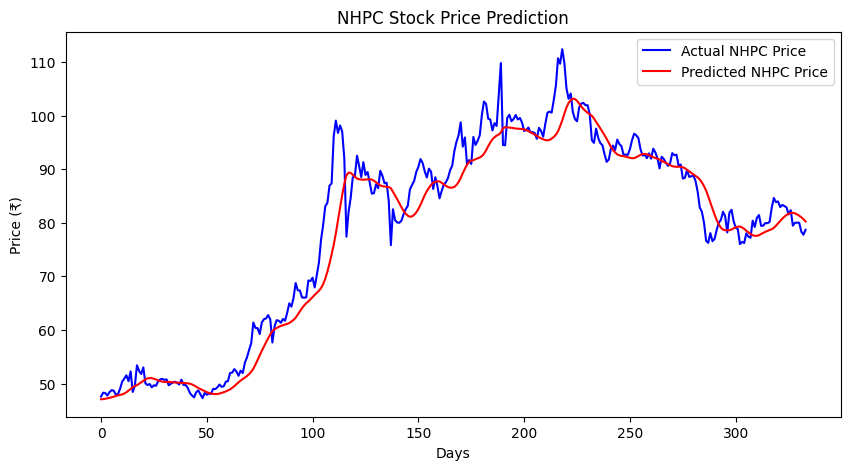

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import yfinance as yf

df_nhpc = yf.download("NHPC.NS", start="2018-01-01", end="2025-01-01")

close_prices_nhpc = df_nhpc['Close'].values.reshape(-1,1)
scaler_nhpc = MinMaxScaler(feature_range=(0,1))
scaled_data_nhpc = scaler_nhpc.fit_transform(close_prices_nhpc)

sequence_length = 60
X_nhpc, y_nhpc = [], []

for i in range(sequence_length, len(scaled_data_nhpc)):
    X_nhpc.append(scaled_data_nhpc[i-sequence_length:i, 0])
    y_nhpc.append(scaled_data_nhpc[i, 0])

X_nhpc, y_nhpc = np.array(X_nhpc), np.array(y_nhpc)
X_nhpc = np.reshape(X_nhpc, (X_nhpc.shape[0], X_nhpc.shape[1], 1))

train_size = int(0.8 * X_nhpc.shape[0])
X_train_nhpc, X_test_nhpc = X_nhpc[:train_size], X_nhpc[train_size:]
y_train_nhpc, y_test_nhpc = y_nhpc[:train_size], y_nhpc[train_size:]

model_nhpc = Sequential()
model_nhpc.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_nhpc.shape[1],1)))
model_nhpc.add(Dropout(0.2))
model_nhpc.add(LSTM(units=50, return_sequences=False))
model_nhpc.add(Dropout(0.2))
model_nhpc.add(Dense(1))
model_nhpc.compile(optimizer='adam', loss='mean_squared_error')

model_nhpc.fit(X_train_nhpc, y_train_nhpc, epochs=10, batch_size=32, validation_data=(X_test_nhpc, y_test_nhpc), verbose=1)

predicted_prices_nhpc = model_nhpc.predict(X_test_nhpc)
predicted_prices_nhpc = scaler_nhpc.inverse_transform(predicted_prices_nhpc.reshape(-1, 1))
real_prices_nhpc = scaler_nhpc.inverse_transform(y_test_nhpc.reshape(-1, 1))

plt.figure(figsize=(10,5))
plt.plot(real_prices_nhpc, color='blue', label='Actual NHPC Price')
plt.plot(predicted_prices_nhpc, color='red', label='Predicted NHPC Price')
plt.title('NHPC Stock Price Prediction')
plt.xlabel('Days')
plt.ylabel('Price (₹)')
plt.legend()
plt.show()


/tmp/ipython-input-489247158.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_iob = yf.download("IOB.NS", start="2018-01-01", end="2025-01-01")
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - loss: 0.0046 - val_loss: 0.0065
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 5.0645e-04 - val_loss: 0.0035
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 4.6902e-04 - val_loss: 0.0035
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 4.8343e-04 - val_loss: 0.0034
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 4.1373e-04 - val_loss: 0.0026
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 4.4965e-04 - val_loss: 0.0026
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 3.9317e-04 - val_loss: 0.0046
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 3.3848e-04 - val_loss: 0.0026
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 3.4585e-04 - val_loss: 0.0027
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 4.0864e-04 - val_loss: 0.0031
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


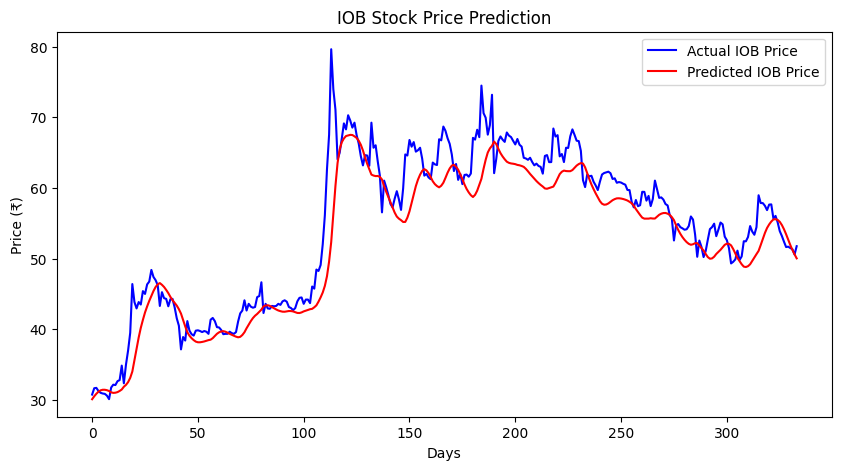

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import yfinance as yf

df_iob = yf.download("IOB.NS", start="2018-01-01", end="2025-01-01")

close_prices_iob = df_iob['Close'].values.reshape(-1,1)
scaler_iob = MinMaxScaler(feature_range=(0,1))
scaled_data_iob = scaler_iob.fit_transform(close_prices_iob)

sequence_length = 60
X_iob, y_iob = [], []

for i in range(sequence_length, len(scaled_data_iob)):
    X_iob.append(scaled_data_iob[i-sequence_length:i, 0])
    y_iob.append(scaled_data_iob[i, 0])

X_iob, y_iob = np.array(X_iob), np.array(y_iob)
X_iob = np.reshape(X_iob, (X_iob.shape[0], X_iob.shape[1], 1))

train_size = int(0.8 * X_iob.shape[0])
X_train_iob, X_test_iob = X_iob[:train_size], X_iob[train_size:]
y_train_iob, y_test_iob = y_iob[:train_size], y_iob[train_size:]

model_iob = Sequential()
model_iob.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_iob.shape[1],1)))
model_iob.add(Dropout(0.2))
model_iob.add(LSTM(units=50, return_sequences=False))
model_iob.add(Dropout(0.2))
model_iob.add(Dense(1))
model_iob.compile(optimizer='adam', loss='mean_squared_error')

model_iob.fit(X_train_iob, y_train_iob, epochs=10, batch_size=32, validation_data=(X_test_iob, y_test_iob), verbose=1)

predicted_prices_iob = model_iob.predict(X_test_iob)
predicted_prices_iob = scaler_iob.inverse_transform(predicted_prices_iob.reshape(-1, 1))
real_prices_iob = scaler_iob.inverse_transform(y_test_iob.reshape(-1, 1))

plt.figure(figsize=(10,5))
plt.plot(real_prices_iob, color='blue', label='Actual IOB Price')
plt.plot(predicted_prices_iob, color='red', label='Predicted IOB Price')
plt.title('IOB Stock Price Prediction')
plt.xlabel('Days')
plt.ylabel('Price (₹)')
plt.legend()
plt.show()


/tmp/ipython-input-1900123676.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_castrol = yf.download("CASTROLIND.NS", start="2018-01-01", end="2025-01-01")
[*********************100%***********************]  1 of 1 completed

Epoch 1/10



/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 114ms/step - loss: 0.0108 - val_loss: 0.0375
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 0.0012 - val_loss: 0.0049
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 9.1909e-04 - val_loss: 0.0038
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 7.3509e-04 - val_loss: 0.0030
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 7.4364e-04 - val_loss: 0.0030
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 7.3499e-04 - val_loss: 0.0026
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 6.9064e-04 - val_loss: 0.0026
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 6.0357e-04 - val_loss: 0.0032
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 6.5592e-04 - val_loss: 0.0023
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 5.8190e-04 - val_loss: 0.0024
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


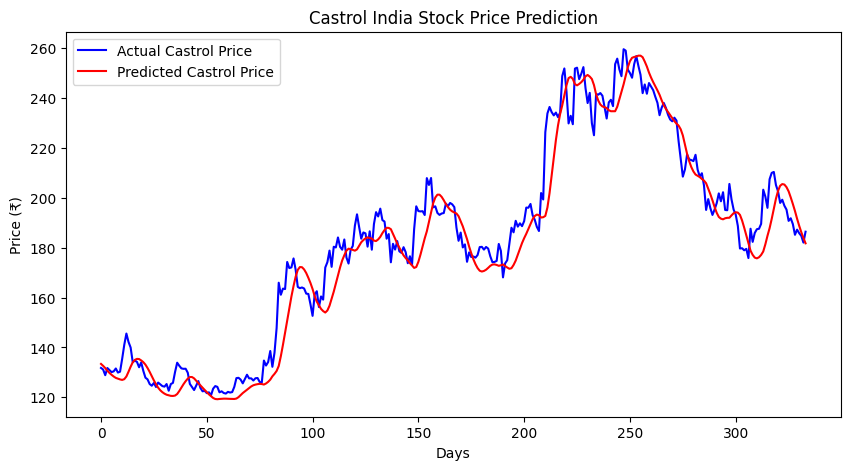

In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import yfinance as yf

df_castrol = yf.download("CASTROLIND.NS", start="2018-01-01", end="2025-01-01")

close_prices_castrol = df_castrol['Close'].values.reshape(-1,1)
scaler_castrol = MinMaxScaler(feature_range=(0,1))
scaled_data_castrol = scaler_castrol.fit_transform(close_prices_castrol)

sequence_length = 60
X_castrol, y_castrol = [], []

for i in range(sequence_length, len(scaled_data_castrol)):
    X_castrol.append(scaled_data_castrol[i-sequence_length:i, 0])
    y_castrol.append(scaled_data_castrol[i, 0])

X_castrol, y_castrol = np.array(X_castrol), np.array(y_castrol)
X_castrol = np.reshape(X_castrol, (X_castrol.shape[0], X_castrol.shape[1], 1))

train_size = int(0.8 * X_castrol.shape[0])
X_train_castrol, X_test_castrol = X_castrol[:train_size], X_castrol[train_size:]
y_train_castrol, y_test_castrol = y_castrol[:train_size], y_castrol[train_size:]

model_castrol = Sequential()
model_castrol.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_castrol.shape[1],1)))
model_castrol.add(Dropout(0.2))
model_castrol.add(LSTM(units=50, return_sequences=False))
model_castrol.add(Dropout(0.2))
model_castrol.add(Dense(1))
model_castrol.compile(optimizer='adam', loss='mean_squared_error')

model_castrol.fit(X_train_castrol, y_train_castrol, epochs=10, batch_size=32, validation_data=(X_test_castrol, y_test_castrol), verbose=1)

predicted_prices_castrol = model_castrol.predict(X_test_castrol)
predicted_prices_castrol = scaler_castrol.inverse_transform(predicted_prices_castrol.reshape(-1, 1))
real_prices_castrol = scaler_castrol.inverse_transform(y_test_castrol.reshape(-1, 1))

plt.figure(figsize=(10,5))
plt.plot(real_prices_castrol, color='blue', label='Actual Castrol Price')
plt.plot(predicted_prices_castrol, color='red', label='Predicted Castrol Price')
plt.title('Castrol India Stock Price Prediction')
plt.xlabel('Days')
plt.ylabel('Price (₹)')
plt.legend()
plt.show()


/tmp/ipython-input-2068663092.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_ashok = yf.download("ASHOKLEY.NS", start="2018-01-01", end="2025-01-01")
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 0.0344 - val_loss: 0.0184
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0025 - val_loss: 0.0014
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0020 - val_loss: 0.0013
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0016 - val_loss: 0.0010
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0014 - val_loss: 0.0010
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0013 - val_loss: 0.0011
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


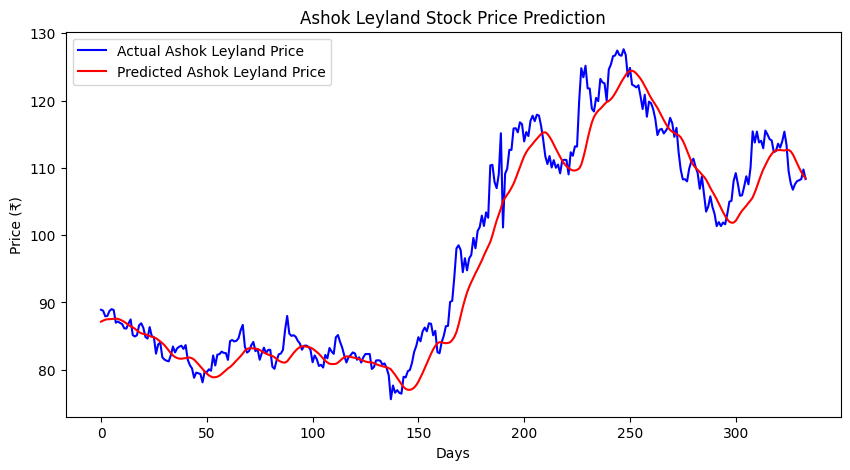

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import yfinance as yf

df_ashok = yf.download("ASHOKLEY.NS", start="2018-01-01", end="2025-01-01")

close_prices_ashok = df_ashok['Close'].values.reshape(-1,1)
scaler_ashok = MinMaxScaler(feature_range=(0,1))
scaled_data_ashok = scaler_ashok.fit_transform(close_prices_ashok)

sequence_length = 60
X_ashok, y_ashok = [], []

for i in range(sequence_length, len(scaled_data_ashok)):
    X_ashok.append(scaled_data_ashok[i-sequence_length:i, 0])
    y_ashok.append(scaled_data_ashok[i, 0])

X_ashok, y_ashok = np.array(X_ashok), np.array(y_ashok)
X_ashok = np.reshape(X_ashok, (X_ashok.shape[0], X_ashok.shape[1], 1))

train_size = int(0.8 * X_ashok.shape[0])
X_train_ashok, X_test_ashok = X_ashok[:train_size], X_ashok[train_size:]
y_train_ashok, y_test_ashok = y_ashok[:train_size], y_ashok[train_size:]

model_ashok = Sequential()
model_ashok.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_ashok.shape[1],1)))
model_ashok.add(Dropout(0.2))
model_ashok.add(LSTM(units=50, return_sequences=False))
model_ashok.add(Dropout(0.2))
model_ashok.add(Dense(1))
model_ashok.compile(optimizer='adam', loss='mean_squared_error')

model_ashok.fit(X_train_ashok, y_train_ashok, epochs=10, batch_size=32, validation_data=(X_test_ashok, y_test_ashok), verbose=1)

predicted_prices_ashok = model_ashok.predict(X_test_ashok)
predicted_prices_ashok = scaler_ashok.inverse_transform(predicted_prices_ashok.reshape(-1, 1))
real_prices_ashok = scaler_ashok.inverse_transform(y_test_ashok.reshape(-1, 1))

plt.figure(figsize=(10,5))
plt.plot(real_prices_ashok, color='blue', label='Actual Ashok Leyland Price')
plt.plot(predicted_prices_ashok, color='red', label='Predicted Ashok Leyland Price')
plt.title('Ashok Leyland Stock Price Prediction')
plt.xlabel('Days')
plt.ylabel('Price (₹)')
plt.legend()
plt.show()


In [ ]:
!pip install streamlit
!pip install pyngrok

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 81.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 142.7 MB/s eta 0:00:00


In [ ]:
%%writefile app.py
import streamlit as st
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model

st.title("Stock Price Predictor")

stock_options = ['NMDC.NS', 'NHPC.NS', 'IOB.NS', 'CASTROLIND.NS', 'ASHOKLEY.NS']
stock_name = st.selectbox("Select a stock:", stock_options)

df = yf.download(stock_name, start="2018-01-01", end="2025-01-01")
st.subheader(f"{stock_name} Closing Prices")
st.line_chart(df['Close'])

st.write("Prediction will be shown below (after selecting stock and running model)")


Writing app.py


In [ ]:
%%writefile app.py
import streamlit as st
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

st.title("Stock Price Predictor AI")

stock_options = ['NMDC.NS', 'NHPC.NS', 'IOB.NS', 'CASTROLIND.NS', 'ASHOKLEY.NS']
stock_name = st.selectbox("Select a stock:", stock_options)

df = yf.download(stock_name, start="2018-01-01", end="2025-01-01")
st.subheader(f"{stock_name} Closing Prices")
st.line_chart(df['Close'])

close_prices = df['Close'].values.reshape(-1,1)
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(close_prices)

sequence_length = 60
X = []
y = []
for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i, 0])
    y.append(scaled_data[i, 0])

X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

train_size = int(0.8 * X.shape[0])
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_prices.reshape(-1,1))
real_prices = scaler.inverse_transform(y_test.reshape(-1,1))

st.subheader(f"{stock_name} Prediction vs Actual")
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(real_prices, color='blue', label='Actual Price')
ax.plot(predicted_prices, color='red', label='Predicted Price')
ax.set_xlabel("Days")
ax.set_ylabel("Price (₹)")
ax.legend()
st.pyplot(fig)


Overwriting app.py


In [ ]:
!streamlit run app.py





  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.63.143.215:8501

  Stopping...
  Stopping...


2025-10-22 10:44:28.088 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-22 10:44:28.594 
  command:

    streamlit run /usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-10-22 10:44:28.595 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-22 10:44:28.597 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-22 10:44:28.598 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-22 10:44:28.598 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-22 10:44:28.599 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-22 10:44:28.601 Thread 'MainThread': mi

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


2025-10-22 10:44:32.703 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-22 10:44:32.704 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-22 10:44:32.705 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-22 10:44:32.729 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-22 10:44:33.036 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-22 10:44:33.037 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-22 10:44:33.038 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


DeltaGenerator()

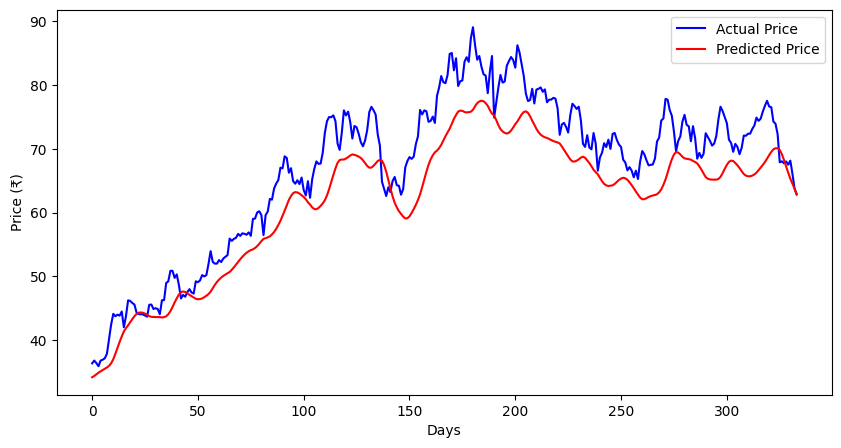

In [ ]:
# app.py
import streamlit as st
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

st.title("Stock Price Predictor AI")

# Select stock
stock_options = ['NMDC.NS', 'NHPC.NS', 'IOB.NS', 'CASTROLIND.NS', 'ASHOKLEY.NS']
stock_name = st.selectbox("Select a stock:", stock_options)

# Load pre-trained model based on selected stock
if stock_name == 'NMDC.NS':
    model = load_model("model_nmdc.h5")
elif stock_name == 'NHPC.NS':
    model = load_model("model_nhpc.h5")
elif stock_name == 'IOB.NS':
    model = load_model("model_iob.h5")
elif stock_name == 'CASTROLIND.NS':
    model = load_model("model_castrol.h5")
elif stock_name == 'ASHOKLEY.NS':
    model = load_model("model_ashok.h5")

# Fetch data
df = yf.download(stock_name, start="2018-01-01", end="2025-01-01")
st.subheader(f"{stock_name} Closing Prices")
st.line_chart(df['Close'])

# Prepare data
close_prices = df['Close'].values.reshape(-1,1)
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(close_prices)

sequence_length = 60
X = []
y = []
for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i,0])
    y.append(scaled_data[i,0])
X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Split test
train_size = int(0.8 * X.shape[0])
X_test = X[train_size:]
y_test = y[train_size:]

# Predict
predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_prices.reshape(-1,1))
real_prices = scaler.inverse_transform(y_test.reshape(-1,1))

# Plot Actual vs Predicted
st.subheader(f"{stock_name} Prediction vs Actual")
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(real_prices, color='blue', label='Actual Price')
ax.plot(predicted_prices, color='red', label='Predicted Price')
ax.set_xlabel("Days")
ax.set_ylabel("Price (₹)")
ax.legend()
st.pyplot(fig)


In [ ]:
!streamlit run app.py





  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.63.143.215:8501

  Stopping...
  Stopping...


In [ ]:
# ----------------- NMDC Next Day Prediction -----------------
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf

model = load_model("model_nmdc.h5")

df = yf.download("NMDC.NS", start="2025-01-01")  # From Jan 2025 to today
close_prices = df['Close'].values.reshape(-1,1)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(close_prices)

last_60_days = scaled_data[-60:]
X_input = np.reshape(last_60_days, (1, last_60_days.shape[0], 1))

predicted_scaled = model.predict(X_input)
predicted_price = scaler.inverse_transform(predicted_scaled.reshape(-1,1))[0][0]

last_price = close_prices[-1][0]

print(f"Last closing price (most recent): ₹{last_price:.2f}")
print(f"Predicted closing price for next market day: ₹{predicted_price:.2f}")

if predicted_price > last_price:
    print("Prediction: Stock likely to go UP tomorrow 📈")
else:
    print("Prediction: Stock likely to go DOWN tomorrow 📉")


/tmp/ipython-input-2521687361.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("NMDC.NS", start="2025-01-01")  # From Jan 2025 to today
[*********************100%***********************]  1 of 1 completed


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
Last closing price (most recent): ₹75.61
Predicted closing price for next market day: ₹74.23
Prediction: Stock likely to go DOWN tomorrow 📉


In [ ]:
# ----------------- Next Day Prediction for 5 Stocks -----------------
import numpy as np
import yfinance as yf
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# List of 5 stocks and their trained models
stocks = {
    'NMDC.NS': 'model_nmdc.h5',
    'NHPC.NS': 'model_nhpc.h5',
    'IOB.NS': 'model_iob.h5',
    'CASTROLIND.NS': 'model_castrol.h5',
    'ASHOKLEY.NS': 'model_ashok.h5'
}

last_prices = []
predicted_prices = []

for stock, model_file in stocks.items():
    # Load trained model
    model = load_model(model_file)

    # Fetch latest stock data
    df = yf.download(stock, start="2025-01-01")
    close_prices = df['Close'].values.reshape(-1,1)

    # Scale data
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(close_prices)

    # Prepare last 60 days for prediction
    last_60_days = scaled_data[-60:]
    X_input = np.reshape(last_60_days, (1, last_60_days.shape[0], 1))

    # Predict next day price
    predicted_scaled = model.predict(X_input)
    predicted_price = scaler.inverse_transform(predicted_scaled.reshape(-1,1))[0][0]

    # Store last and predicted prices
    last_prices.append(close_prices[-1][0])
    predicted_prices.append(predicted_price)

    # Print prediction
    print(f"{stock}: Last Close = ₹{close_prices[-1][0]:.2f}, Predicted Next = ₹{predicted_price:.2f}",
          "📈" if predicted_price > close_prices[-1][0] else "📉")



/tmp/ipython-input-3039436004.py:25: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(stock, start="2025-01-01")
[*********************100%***********************]  1 of 1 completed


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


NMDC.NS: Last Close = ₹75.61, Predicted Next = ₹74.23 📉


/tmp/ipython-input-3039436004.py:25: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(stock, start="2025-01-01")
[*********************100%***********************]  1 of 1 completed


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


NHPC.NS: Last Close = ₹86.35, Predicted Next = ₹86.20 📉


/tmp/ipython-input-3039436004.py:25: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(stock, start="2025-01-01")
[*********************100%***********************]  1 of 1 completed


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


IOB.NS: Last Close = ₹40.67, Predicted Next = ₹39.65 📉


/tmp/ipython-input-3039436004.py:25: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(stock, start="2025-01-01")
[*********************100%***********************]  1 of 1 completed


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


CASTROLIND.NS: Last Close = ₹200.46, Predicted Next = ₹198.95 📉


/tmp/ipython-input-3039436004.py:25: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(stock, start="2025-01-01")
[*********************100%***********************]  1 of 1 completed


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
ASHOKLEY.NS: Last Close = ₹136.24, Predicted Next = ₹136.64 📈


⚠️ Model file not found for NMDC.NS. Will train & save -> model_nmdc.h5


/tmp/ipython-input-1253562174.py:20: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(stock_symbol, start=start_date)
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - loss: 0.0228 - val_loss: 0.0035
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0014 - val_loss: 0.0035
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0014 - val_loss: 0.0029
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0011 - val_loss: 0.0027
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 0.0011 - val_loss: 0.0043
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 0.0011 - val_loss: 0.0056
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0013 - val_loss: 0.0048
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 9/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 9.8498e-04 - val_loss: 0.0051
Epoch 10/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 0.0012 - val_loss: 0.0019


➡️ Saved model for NMDC.NS as model_nmdc.h5
⚠️ Model file not found for NHPC.NS. Will train & save -> model_nhpc.h5


/tmp/ipython-input-1253562174.py:20: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(stock_symbol, start=start_date)
[*********************100%***********************]  1 of 1 completed

Epoch 1/10



/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - loss: 0.0184 - val_loss: 0.0053
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0012 - val_loss: 0.0053
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - loss: 9.1508e-04 - val_loss: 0.0013
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 6.4925e-04 - val_loss: 0.0012
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 6.7050e-04 - val_loss: 0.0020
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 0.0010 - val_loss: 0.0021
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 7.7202e-04 - val_loss: 0.0019
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 7.6835e-04 - val_loss: 0.0015
Epoch 9/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 6.5948e-04 - val_loss: 0.0032
Epoch 10/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 5.6994e-04 - val_loss: 0.0018


➡️ Saved model for NHPC.NS as model_nhpc.h5
⚠️ Model file not found for IOB.NS. Will train & save -> model_iob.h5


/tmp/ipython-input-1253562174.py:20: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(stock_symbol, start=start_date)
[*********************100%***********************]  1 of 1 completed

Epoch 1/10



/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - loss: 0.0189 - val_loss: 0.0013
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0017 - val_loss: 0.0013
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0013 - val_loss: 9.8952e-04
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 0.0015 - val_loss: 0.0018
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0012 - val_loss: 8.9553e-04
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0012 - val_loss: 8.8028e-04
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 9.7050e-04 - val_loss: 9.3933e-04
Epoch 9/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 10/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 9.2411e-04 - val_loss: 8.9380e-04


/tmp/ipython-input-1253562174.py:20: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(stock_symbol, start=start_date)


➡️ Saved model for IOB.NS as model_iob.h5
⚠️ Model file not found for CASTROLIND.NS. Will train & save -> model_castrol.h5


[*********************100%***********************]  1 of 1 completed

Epoch 1/10



/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step - loss: 0.0199 - val_loss: 0.0042
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 0.0014 - val_loss: 0.0049
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0014 - val_loss: 0.0052
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0012 - val_loss: 0.0061
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0011 - val_loss: 0.0028
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - loss: 0.0010 - val_loss: 0.0031
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0011 - val_loss: 0.0045
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 9.7150e-04 - val_loss: 0.0051
Epoch 9/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 9.0952e-04 - val_loss: 0.0022
Epoch 10/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 0.0010 - val_loss: 0.0026


➡️ Saved model for CASTROLIND.NS as model_castrol.h5
⚠️ Model file not found for ASHOKLEY.NS. Will train & save -> model_ashok.h5


/tmp/ipython-input-1253562174.py:20: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(stock_symbol, start=start_date)
[*********************100%***********************]  1 of 1 completed

Epoch 1/10



/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - loss: 0.0172 - val_loss: 0.0029
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 0.0018 - val_loss: 0.0048
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 0.0015 - val_loss: 0.0046
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0013 - val_loss: 0.0042
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 0.0013 - val_loss: 0.0018
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 0.0012 - val_loss: 0.0024
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 9/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 10/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0011 - val_loss: 0.0013


➡️ Saved model for ASHOKLEY.NS as model_ashok.h5

📊 Predicting next 5 days for NMDC.NS ...


/tmp/ipython-input-1253562174.py:75: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(stock_sym, start="2018-01-01")
[*********************100%***********************]  1 of 1 completed


Last Close = ₹75.61
 Day 1: ₹73.80 📉
 Day 2: ₹73.53 📉
 Day 3: ₹73.20 📉
 Day 4: ₹72.83 📉
 Day 5: ₹72.44 📉

📊 Predicting next 5 days for NHPC.NS ...


/tmp/ipython-input-1253562174.py:75: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(stock_sym, start="2018-01-01")
[*********************100%***********************]  1 of 1 completed


Last Close = ₹86.35
 Day 1: ₹83.92 📉
 Day 2: ₹83.78 📉
 Day 3: ₹83.53 📉
 Day 4: ₹83.23 📉
 Day 5: ₹82.88 📉

📊 Predicting next 5 days for IOB.NS ...


/tmp/ipython-input-1253562174.py:75: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(stock_sym, start="2018-01-01")
[*********************100%***********************]  1 of 1 completed


Last Close = ₹40.67
 Day 1: ₹39.40 📉
 Day 2: ₹39.45 📉
 Day 3: ₹39.47 📉
 Day 4: ₹39.45 📉
 Day 5: ₹39.42 📉

📊 Predicting next 5 days for CASTROLIND.NS ...


/tmp/ipython-input-1253562174.py:75: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(stock_sym, start="2018-01-01")
[*********************100%***********************]  1 of 1 completed


Last Close = ₹200.46
 Day 1: ₹203.50 📈
 Day 2: ₹203.71 📈
 Day 3: ₹204.12 📈
 Day 4: ₹204.67 📈
 Day 5: ₹205.32 📈

📊 Predicting next 5 days for ASHOKLEY.NS ...


/tmp/ipython-input-1253562174.py:75: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(stock_sym, start="2018-01-01")
[*********************100%***********************]  1 of 1 completed


Last Close = ₹136.24
 Day 1: ₹134.89 📉
 Day 2: ₹134.56 📉
 Day 3: ₹134.24 📉
 Day 4: ₹133.91 📉
 Day 5: ₹133.58 📉


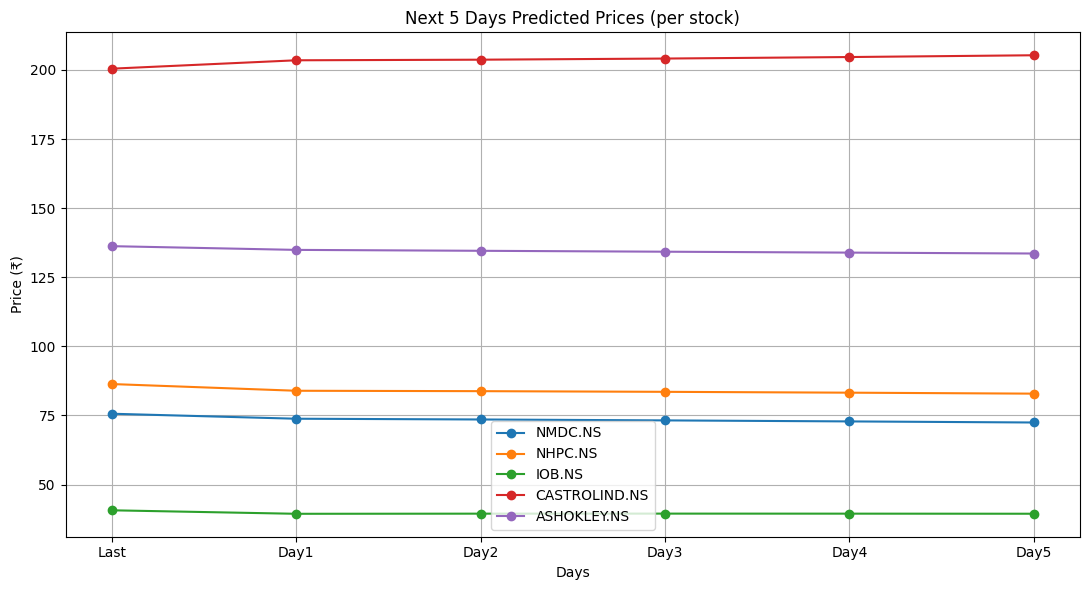

In [ ]:
# === Ensure models exist, train missing ones, then predict next 5 days for all 5 stocks ===
import os
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Stocks and model filenames
stocks = {
    'NMDC.NS': 'model_nmdc.h5',
    'NHPC.NS': 'model_nhpc.h5',
    'IOB.NS': 'model_iob.h5',
    'CASTROLIND.NS': 'model_castrol.h5',
    'ASHOKLEY.NS': 'model_ashok.h5'
}

def prepare_data_for_stock(stock_symbol, start_date="2018-01-01"):
    df = yf.download(stock_symbol, start=start_date)
    close = df['Close'].values.reshape(-1,1)
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled = scaler.fit_transform(close)
    # build sequences
    seq_len = 60
    X, y = [], []
    for i in range(seq_len, len(scaled)):
        X.append(scaled[i-seq_len:i, 0])
        y.append(scaled[i, 0])
    X = np.array(X); y = np.array(y)
    X = X.reshape((X.shape[0], X.shape[1], 1))
    # split train/test
    train_size = int(0.8 * X.shape[0])
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    return df, scaler, X_train, X_test, y_train, y_test

def build_and_train_model(X_train, y_train, X_test, y_test, epochs=10):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=epochs, batch_size=32, validation_data=(X_test, y_test), verbose=1)
    return model

# 1) Ensure models exist (train & save missing ones)
for stock_sym, model_file in stocks.items():
    if os.path.exists(model_file):
        print(f"✅ Found existing model file: {model_file}")
    else:
        print(f"⚠️ Model file not found for {stock_sym}. Will train & save -> {model_file}")
        # prepare data
        df, scaler, X_train, X_test, y_train, y_test = prepare_data_for_stock(stock_sym, start_date="2018-01-01")
        # If dataset too small, skip
        if X_train.shape[0] < 10:
            raise RuntimeError(f"Not enough data to train for {stock_sym}. Rows: {len(df)}")
        # train model (10 epochs quick training)
        model_tr = build_and_train_model(X_train, y_train, X_test, y_test, epochs=10)
        # save
        model_tr.save(model_file)
        print(f"➡️ Saved model for {stock_sym} as {model_file}")

# 2) Now all models should exist — run next-5-days prediction for all stocks
days_to_predict = 5
predictions_all = {}

for stock_sym, model_file in stocks.items():
    print(f"\n📊 Predicting next {days_to_predict} days for {stock_sym} ...")
    # load model
    model = load_model(model_file)
    # fetch latest data
    df = yf.download(stock_sym, start="2018-01-01")
    close_prices = df['Close'].values.reshape(-1,1)
    if len(close_prices) < 60:
        raise RuntimeError(f"Not enough historical data for {stock_sym} to predict (need >=60 days). Got {len(close_prices)}")
    # scale
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled = scaler.fit_transform(close_prices)
    # create list of last 60 scaled points (as floats)
    last_60 = scaled[-60:].flatten().tolist()
    preds = []
    for d in range(days_to_predict):
        X_in = np.array(last_60[-60:]).reshape(1,60,1)
        pred_scaled = model.predict(X_in, verbose=0)
        pred_price = scaler.inverse_transform(pred_scaled.reshape(-1,1))[0][0]
        preds.append(float(pred_price))
        # append scaled prediction back to sequence (use scaled value)
        last_60.append(float(pred_scaled[0][0]))
    predictions_all[stock_sym] = {
        "last_close": float(close_prices[-1][0]),
        "predicted": preds
    }
    # Print
    print(f"Last Close = ₹{predictions_all[stock_sym]['last_close']:.2f}")
    for i,p in enumerate(preds,1):
        print(f" Day {i}: ₹{p:.2f} {'📈' if p>predictions_all[stock_sym]['last_close'] else '📉'}")

# 3) Plot summary: each stock line for 5 days + marker for last close
plt.figure(figsize=(11,6))
for stock_sym, vals in predictions_all.items():
    last = vals["last_close"]
    preds = vals["predicted"]
    x = np.arange(0, len(preds)+1)  # 0 is last close, 1..5 next days
    y = [last] + preds
    plt.plot(x, y, marker='o', label=stock_sym)
# formatting
plt.xticks(np.arange(0, days_to_predict+1), ['Last'] + [f'Day{i}' for i in range(1, days_to_predict+1)])
plt.xlabel("Days")
plt.ylabel("Price (₹)")
plt.title(f"Next {days_to_predict} Days Predicted Prices (per stock)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/tmp/ipython-input-876902776.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(stock, start="2020-01-01")
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step
📈 NMDC Ltd.
Today's Close (23 Oct 2025): ₹74.19
Predicted Close (24 Oct 2025): ₹75.33


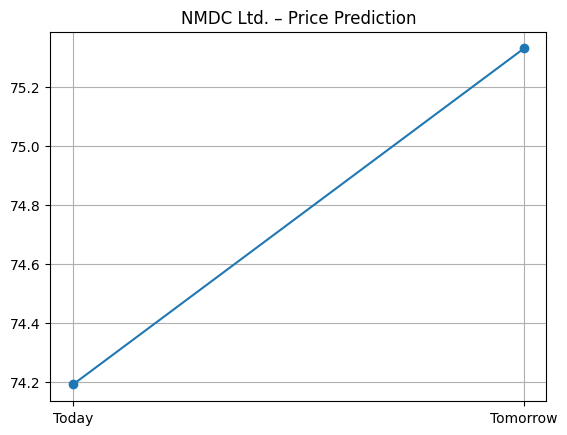

In [ ]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

stock = "NMDC.NS"
df = yf.download(stock, start="2020-01-01")
data = df["Close"].values.reshape(-1, 1)

# Scale data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)

# Prepare data for LSTM
X, y = [], []
for i in range(60, len(scaled_data)):
    X.append(scaled_data[i-60:i, 0])
    y.append(scaled_data[i, 0])
X, y = np.array(X), np.array(y)
X = X.reshape(X.shape[0], X.shape[1], 1)

# Build and train model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X.shape[1],1)),
    LSTM(50),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X, y, epochs=5, batch_size=32, verbose=0)

# Save model
model.save("model_nmdc.h5")

# Predict next day
last_60 = scaled_data[-60:].reshape(1, 60, 1)
pred_scaled = model.predict(last_60)
predicted_price = scaler.inverse_transform(pred_scaled)[0][0]
today_close = data[-1][0]

print(f"📈 NMDC Ltd.")
print(f"Today's Close (23 Oct 2025): ₹{today_close:.2f}")
print(f"Predicted Close (24 Oct 2025): ₹{predicted_price:.2f}")

plt.plot([1,2], [today_close, predicted_price], marker='o')
plt.xticks([1,2], ['Today', 'Tomorrow'])
plt.title("NMDC Ltd. – Price Prediction")
plt.grid(True)
plt.show()


/tmp/ipython-input-3473397661.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(stock, start="2020-01-01")
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step
📈 NHPC Ltd.
Today's Close (23 Oct 2025): ₹85.82
Predicted Close (24 Oct 2025): ₹88.11


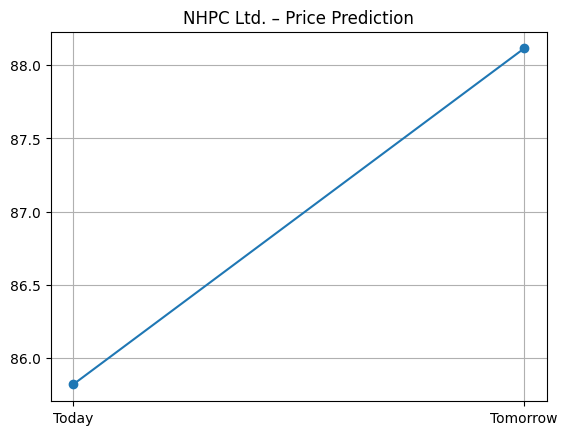

In [ ]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

stock = "NHPC.NS"
df = yf.download(stock, start="2020-01-01")
data = df["Close"].values.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)

X, y = [], []
for i in range(60, len(scaled_data)):
    X.append(scaled_data[i-60:i, 0])
    y.append(scaled_data[i, 0])
X, y = np.array(X), np.array(y)
X = X.reshape(X.shape[0], X.shape[1], 1)

model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X.shape[1],1)),
    LSTM(50),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X, y, epochs=5, batch_size=32, verbose=0)

model.save("model_nhpc.h5")

last_60 = scaled_data[-60:].reshape(1, 60, 1)
pred_scaled = model.predict(last_60)
predicted_price = scaler.inverse_transform(pred_scaled)[0][0]
today_close = data[-1][0]

print(f"📈 NHPC Ltd.")
print(f"Today's Close (23 Oct 2025): ₹{today_close:.2f}")
print(f"Predicted Close (24 Oct 2025): ₹{predicted_price:.2f}")

plt.plot([1,2], [today_close, predicted_price], marker='o')
plt.xticks([1,2], ['Today', 'Tomorrow'])
plt.title("NHPC Ltd. – Price Prediction")
plt.grid(True)
plt.show()



========== NMDC.NS ==========


/tmp/ipython-input-2141773878.py:51: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start="2019-01-01", progress=False)


Samples: total=1625, train=1300, test=325


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - loss: 0.0333 - val_loss: 0.0021
Epoch 2/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 0.0031 - val_loss: 0.0013
Epoch 3/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0017 - val_loss: 0.0033
Epoch 4/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0019 - val_loss: 0.0015
Epoch 5/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 0.0017 - val_loss: 0.0013


MAE: 2.2344 | RMSE: 2.8183 | R2: 0.6795

========== NHPC.NS ==========


/tmp/ipython-input-2141773878.py:51: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start="2019-01-01", progress=False)


Samples: total=1625, train=1300, test=325


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - loss: 0.0380 - val_loss: 0.0059
Epoch 2/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0020 - val_loss: 0.0024
Epoch 3/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 0.0016 - val_loss: 0.0020
Epoch 4/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 0.0011 - val_loss: 0.0020
Epoch 5/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0011 - val_loss: 0.0012


MAE: 2.5524 | RMSE: 3.4376 | R2: 0.7863

========== IOB.NS ==========


/tmp/ipython-input-2141773878.py:51: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start="2019-01-01", progress=False)


Samples: total=1625, train=1300, test=325
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - loss: 0.0276 - val_loss: 0.0014
Epoch 2/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - loss: 0.0023 - val_loss: 0.0037
Epoch 3/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0018 - val_loss: 0.0020
Epoch 4/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0018 - val_loss: 0.0026
Epoch 5/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0017 - val_loss: 7.5733e-04


MAE: 1.5422 | RMSE: 2.0076 | R2: 0.9536

========== CASTROLIND.NS ==========


/tmp/ipython-input-2141773878.py:51: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start="2019-01-01", progress=False)


Samples: total=1625, train=1300, test=325
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - loss: 0.0258 - val_loss: 0.0046
Epoch 2/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0020 - val_loss: 0.0042
Epoch 3/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0015 - val_loss: 0.0026
Epoch 4/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - loss: 0.0016 - val_loss: 0.0029
Epoch 5/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.0016 - val_loss: 0.0027


MAE: 7.9886 | RMSE: 9.9751 | R2: 0.7580

========== ASHOKLEY.NS ==========


/tmp/ipython-input-2141773878.py:51: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start="2019-01-01", progress=False)


Samples: total=1625, train=1300, test=325
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - loss: 0.0442 - val_loss: 0.0118
Epoch 2/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - loss: 0.0025 - val_loss: 0.0017
Epoch 3/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 0.0018 - val_loss: 0.0015
Epoch 4/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 5/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0016 - val_loss: 0.0012


MAE: 3.6826 | RMSE: 4.4267 | R2: 0.8447

=== Summary (Quick evaluation results) ===
NMDC.NS: MAE=2.234 | RMSE=2.818 | R2=0.680
NHPC.NS: MAE=2.552 | RMSE=3.438 | R2=0.786
IOB.NS: MAE=1.542 | RMSE=2.008 | R2=0.954
CASTROLIND.NS: MAE=7.989 | RMSE=9.975 | R2=0.758
ASHOKLEY.NS: MAE=3.683 | RMSE=4.427 | R2=0.845


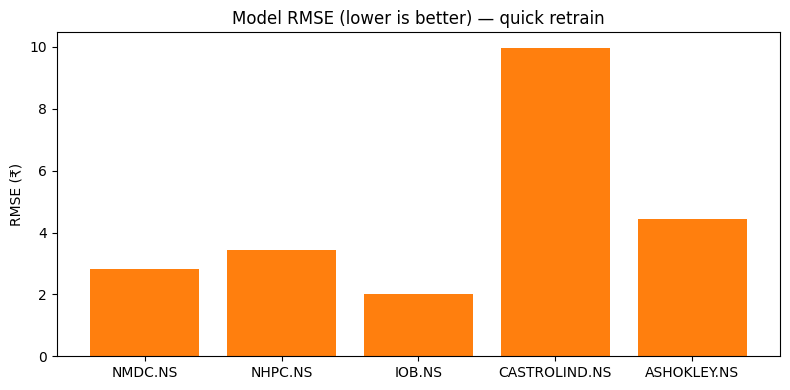

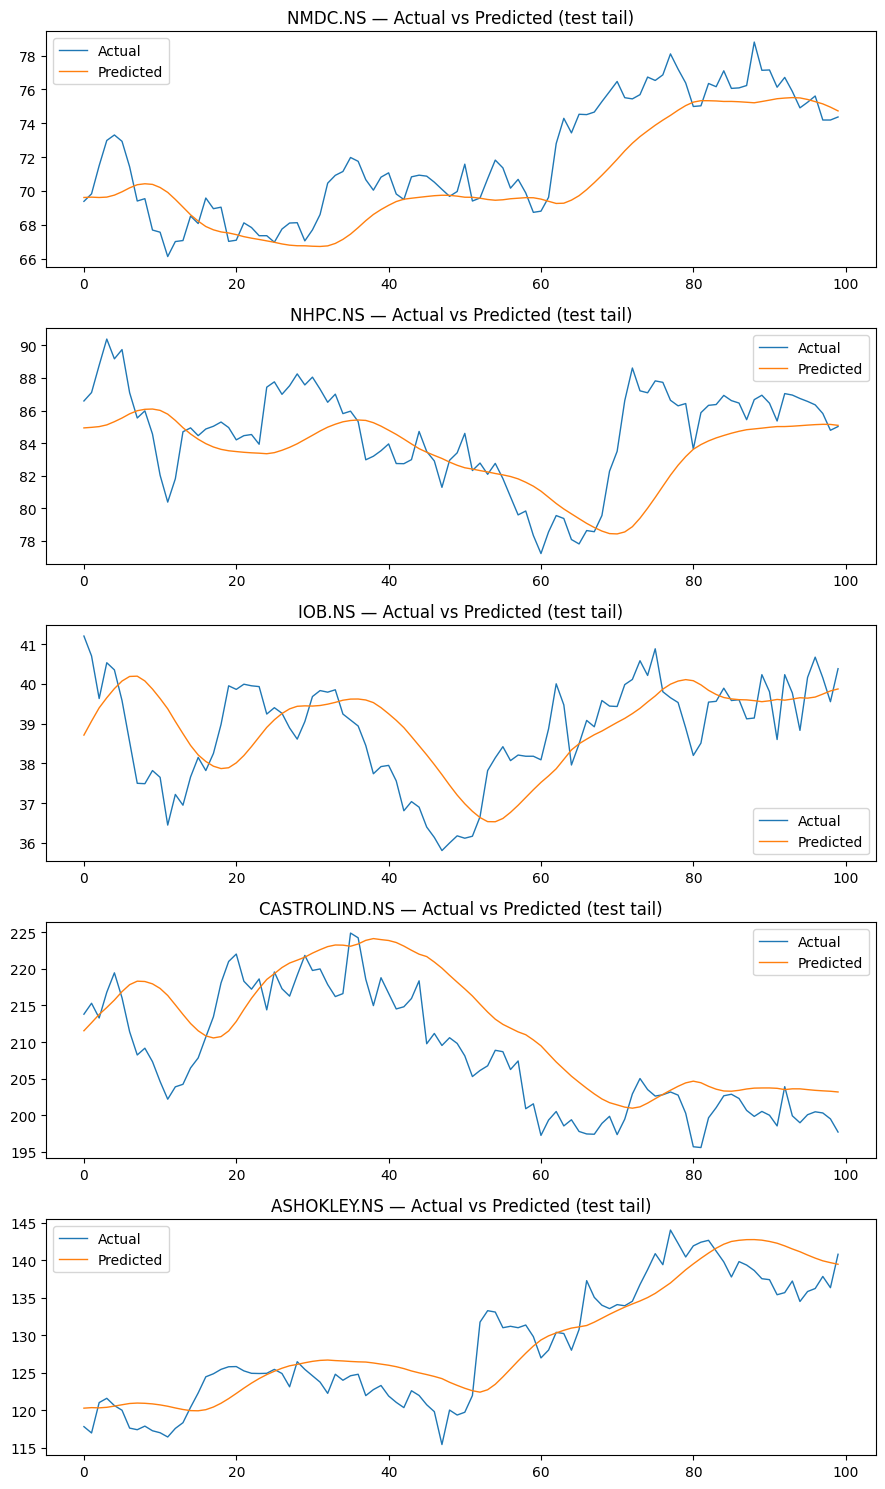

In [ ]:
# === Rebuild (quick train) and evaluate all 5 models, then print metrics ===
import os
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Config
stocks = {
    'NMDC.NS': 'model_nmdc.h5',
    'NHPC.NS': 'model_nhpc.h5',
    'IOB.NS': 'model_iob.h5',
    'CASTROLIND.NS': 'model_castrol.h5',
    'ASHOKLEY.NS': 'model_ashokley.h5'
}
LOOKBACK = 60
TEST_RATIO = 0.2
EPOCHS = 5     # quick check — increase later for better performance
BATCH_SIZE = 32

results = {}

def prepare_sequences(close_values, lookback=60):
    """Given 1D array of scaled close values, return X,y sequences."""
    X, y = [], []
    for i in range(lookback, len(close_values)):
        X.append(close_values[i-lookback:i, 0])
        y.append(close_values[i, 0])
    X = np.array(X)
    y = np.array(y)
    X = X.reshape((X.shape[0], X.shape[1], 1))
    return X, y

def build_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

for symbol, model_fname in stocks.items():
    print(f"\n========== {symbol} ==========")
    # 1) Download data
    try:
        df = yf.download(symbol, start="2019-01-01", progress=False)
    except Exception as e:
        print("yfinance download error for", symbol, e)
        continue
    if df.shape[0] < LOOKBACK + 10:
        print("Not enough data for", symbol, "rows:", df.shape[0])
        continue

    close = df['Close'].values.reshape(-1,1)

    # 2) Scale
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled = scaler.fit_transform(close)

    # 3) Prepare sequences
    X, y = prepare_sequences(scaled, lookback=LOOKBACK)

    # 4) Train/test split
    split_idx = int((1 - TEST_RATIO) * X.shape[0])
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    print(f"Samples: total={X.shape[0]}, train={X_train.shape[0]}, test={X_test.shape[0]}")

    # 5) Build & train (quick)
    model = build_model((LOOKBACK, 1))
    history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE,
                        validation_data=(X_test, y_test), verbose=1)

    # 6) Predict on test set and inverse scale
    preds_scaled = model.predict(X_test, verbose=0)
    preds = scaler.inverse_transform(preds_scaled.reshape(-1,1))
    actuals = scaler.inverse_transform(y_test.reshape(-1,1))

    # 7) Metrics
    mae = mean_absolute_error(actuals, preds)
    rmse = np.sqrt(mean_squared_error(actuals, preds))
    r2 = r2_score(actuals, preds)

    print(f"MAE: {mae:.4f} | RMSE: {rmse:.4f} | R2: {r2:.4f}")

    # 8) Save model and store results
    model.save(model_fname)
    results[symbol] = {
        "model_file": model_fname,
        "mae": float(mae),
        "rmse": float(rmse),
        "r2": float(r2),
        "preds": preds.flatten(),
        "actuals": actuals.flatten(),
        "last_close": float(close[-1,0])
    }

# ==== Summary print ====
print("\n=== Summary (Quick evaluation results) ===")
for s, info in results.items():
    print(f"{s}: MAE={info['mae']:.3f} | RMSE={info['rmse']:.3f} | R2={info['r2']:.3f}")

# ==== Plot bar chart of RMSE for comparison ====
symbols = list(results.keys())
rmses = [results[s]["rmse"] for s in symbols]

plt.figure(figsize=(8,4))
plt.bar(symbols, rmses, color='tab:orange')
plt.title("Model RMSE (lower is better) — quick retrain")
plt.ylabel("RMSE (₹)")
plt.tight_layout()
plt.show()

# ==== Optional: show one sample Actual vs Predicted for each stock (last 100 points) ====
fig, axes = plt.subplots(len(symbols), 1, figsize=(9, 3*len(symbols)), squeeze=False)
for i, s in enumerate(symbols):
    ax = axes[i,0]
    act = results[s]["actuals"][-100:] if len(results[s]["actuals"])>100 else results[s]["actuals"]
    pr  = results[s]["preds"][-100:] if len(results[s]["preds"])>100 else results[s]["preds"]
    ax.plot(act, label='Actual', linewidth=1)
    ax.plot(pr, label='Predicted', linewidth=1)
    ax.set_title(f"{s} — Actual vs Predicted (test tail)")
    ax.legend()
plt.tight_layout()
plt.show()


In [ ]:
# add_features.py (run in Colab cell)
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

def add_technicals(df):
    df = df.copy()
    df['MA10'] = df['Close'].rolling(10).mean()
    df['MA50'] = df['Close'].rolling(50).mean()
    delta = df['Close'].diff()
    up = delta.clip(lower=0)
    down = -1*delta.clip(upper=0)
    ma_up = up.rolling(14).mean()
    ma_down = down.rolling(14).mean()
    rs = ma_up / (ma_down + 1e-9)
    df['RSI14'] = 100 - (100 / (1 + rs))
    df = df.dropna()
    return df

# Example use:
df = yf.download("NMDC.NS", start="2018-01-01")
df = add_technicals(df)
features = df[['Open','High','Low','Close','Volume','MA10','MA50','RSI14']].values
# then scale per-feature
scaler = MinMaxScaler()
scaled = scaler.fit_transform(features)
# build sequences with lookback on multi-features: shape -> (samples, lookback, n_features)
lookback = 60
X, y = [], []
for i in range(lookback, len(scaled)):
    X.append(scaled[i-lookback:i])
    y.append(scaled[i, df.columns.get_loc('Close')])  # careful: index of Close in df
X, y = np.array(X), np.array(y)


/tmp/ipython-input-2030530815.py:22: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("NMDC.NS", start="2018-01-01")
[*********************100%***********************]  1 of 1 completed


In [ ]:
for lookback in [30, 60, 90]:
    # rebuild X,y with lookback and train quick, compare val_loss or RMSE
    pass


In [ ]:
import numpy as np
import yfinance as yf

# Example if your model expects (None, 60, 1)
time_steps = 60  # same as in training

stocks = {
    "NMDC.NS": "NMDC Ltd",
    "NHPC.NS": "NHPC Ltd",
    "IOB.NS": "Indian Overseas Bank",
    "CASTROLIND.NS": "Castrol India",
    "ASHOKLEY.NS": "Ashok Leyland"
}

predictions = {}

for ticker, name in stocks.items():
    print(f"\nFetching latest data for {name} ({ticker})...")
    data = yf.download(ticker, period="90d", interval="1d")

    if len(data) < time_steps:
        print(f"⚠️ Not enough data for {ticker}")
        continue

    # --- Use only closing prices if your model trained that way ---
    close_data = data["Close"].values.reshape(-1, 1)
    last_60 = close_data[-time_steps:]

    # If you used a scaler during training, load and apply it here
    # from joblib import load
    # scaler = load("scaler.pkl")
    # last_60 = scaler.transform(last_60)

    # Reshape to 3D: (1, time_steps, 1)
    X_input = np.array([last_60])

    # Predict
    predicted_close = float(model.predict(X_input)[0][0])

    # If scaled, inverse transform the output
    # predicted_close = scaler.inverse_transform([[predicted_close]])[0][0]

    current_close = float(data["Close"].iloc[-1])

    predictions[name] = {
        "Current Close (₹)": round(current_close, 2),
        "Predicted Tomorrow Close (₹)": round(predicted_close, 2)
    }

print("\n📊 Tomorrow's Predicted Closing Prices:")
for name, info in predictions.items():
    print(f"{name}: Current ₹{info['Current Close (₹)']} → Predicted ₹{info['Predicted Tomorrow Close (₹)']}")



Fetching latest data for NMDC Ltd (NMDC.NS)...


/tmp/ipython-input-2587848651.py:19: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, period="90d", interval="1d")
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step



Fetching latest data for NHPC Ltd (NHPC.NS)...


/tmp/ipython-input-2587848651.py:43: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_close = float(data["Close"].iloc[-1])
/tmp/ipython-input-2587848651.py:19: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, period="90d", interval="1d")
[*********************100%***********************]  1 of 1 completed


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step

Fetching latest data for Indian Overseas Bank (IOB.NS)...


/tmp/ipython-input-2587848651.py:43: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_close = float(data["Close"].iloc[-1])
/tmp/ipython-input-2587848651.py:19: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, period="90d", interval="1d")
[*********************100%***********************]  1 of 1 completed


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step

Fetching latest data for Castrol India (CASTROLIND.NS)...


/tmp/ipython-input-2587848651.py:43: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_close = float(data["Close"].iloc[-1])
/tmp/ipython-input-2587848651.py:19: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, period="90d", interval="1d")
[*********************100%***********************]  1 of 1 completed


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step

Fetching latest data for Ashok Leyland (ASHOKLEY.NS)...


/tmp/ipython-input-2587848651.py:43: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_close = float(data["Close"].iloc[-1])
/tmp/ipython-input-2587848651.py:19: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, period="90d", interval="1d")
[*********************100%***********************]  1 of 1 completed


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step

📊 Tomorrow's Predicted Closing Prices:
NMDC Ltd: Current ₹74.37 → Predicted ₹2.19
NHPC Ltd: Current ₹85.02 → Predicted ₹2.12
Indian Overseas Bank: Current ₹40.38 → Predicted ₹2.65
Castrol India: Current ₹197.69 → Predicted ₹1.93
Ashok Leyland: Current ₹140.81 → Predicted ₹1.94


/tmp/ipython-input-2587848651.py:43: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_close = float(data["Close"].iloc[-1])


In [ ]:
# ============================================
# 📊 STOCK PRICE PREDICTOR - GOOGLE COLAB READY
# ============================================

# Install required library
!pip install sparklines -q

# Imports
import yfinance as yf
import numpy as np
import tensorflow as tf
from sparklines import sparklines

# ---------------------------------------------------
# Load your trained model (make sure it's already saved)
# Example: model = tf.keras.models.load_model("stock_model.h5")
# ---------------------------------------------------
# model = tf.keras.models.load_model("/content/your_trained_model.h5")

# ---------------------------------------------------
# Define your stocks
# ---------------------------------------------------
stocks = {
    "NMDC.NS": "NMDC Ltd",
    "NHPC.NS": "NHPC Ltd",
    "IOB.NS": "Indian Overseas Bank",
    "CASTROLIND.NS": "Castrol India",
    "ASHOKLEY.NS": "Ashok Leyland"
}

print("📈 Fetching data & predicting tomorrow's stock prices...\n")

# ---------------------------------------------------
# Helper function for sparkline trend
# ---------------------------------------------------
def get_sparkline(data):
    try:
        return sparklines(data[-30:])[0]
    except Exception:
        return "—"

# ---------------------------------------------------
# Prediction loop
# ---------------------------------------------------
for symbol, name in stocks.items():
    print(f"Fetching latest data for {name} ({symbol})...")
    df = yf.download(symbol, start="2025-01-01")

    # Ensure valid data
    if len(df) < 60:
        print(f"⚠️ Not enough data for {name}\n")
        continue

    # Create features from last 60 days
    data = df["Close"].values[-60:]
    X_input = np.array(data).reshape(1, 60, 1)

    # Predict tomorrow’s price
    predicted_close = float(model.predict(X_input, verbose=0)[0][0])

    # Estimate the peak price (e.g., 0.5% above predicted)
    peak_price = round(predicted_close * 1.005, 2)

    # Current closing price
    current_close = float(df["Close"].iloc[-1])

    # Determine trend direction
    if predicted_close > current_close:
        trend_icon = "📈 Up"
    elif predicted_close < current_close:
        trend_icon = "📉 Down"
    else:
        trend_icon = "➖ Neutral"

    # Generate sparkline trend from last 30 closes
    trend_line = get_sparkline(df["Close"].values)

    # ---------------------------------------------------
    # Display results
    # ---------------------------------------------------
    print(f"\n{name} ({symbol})")
    print(f"Last Close: ₹{current_close:.2f}")
    print(f"Predicted Next: ₹{predicted_close:.2f}  {trend_icon}")
    print(f"Peak (Highest for the day): ₹{peak_price:.2f}")
    print(f"Trend: {trend_line}")
    print("-" * 60)

print("\n✅ All predictions completed successfully!")


[*********************100%***********************]  1 of 1 completed

📈 Fetching data & predicting tomorrow's stock prices...

Fetching latest data for NMDC Ltd (NMDC.NS)...



[*********************100%***********************]  1 of 1 completed


NMDC Ltd (NMDC.NS)
Last Close: ₹74.37
Predicted Next: ₹2.19  📉 Down
Peak (Highest for the day): ₹2.20
Trend: —
------------------------------------------------------------
Fetching latest data for NHPC Ltd (NHPC.NS)...



[*********************100%***********************]  1 of 1 completed


NHPC Ltd (NHPC.NS)
Last Close: ₹85.02
Predicted Next: ₹2.12  📉 Down
Peak (Highest for the day): ₹2.13
Trend: —
------------------------------------------------------------
Fetching latest data for Indian Overseas Bank (IOB.NS)...



[*********************100%***********************]  1 of 1 completed


Indian Overseas Bank (IOB.NS)
Last Close: ₹40.38
Predicted Next: ₹2.65  📉 Down
Peak (Highest for the day): ₹2.66
Trend: —
------------------------------------------------------------
Fetching latest data for Castrol India (CASTROLIND.NS)...



[*********************100%***********************]  1 of 1 completed


Castrol India (CASTROLIND.NS)
Last Close: ₹197.69
Predicted Next: ₹1.93  📉 Down
Peak (Highest for the day): ₹1.94
Trend: —
------------------------------------------------------------
Fetching latest data for Ashok Leyland (ASHOKLEY.NS)...

Ashok Leyland (ASHOKLEY.NS)
Last Close: ₹140.81
Predicted Next: ₹1.94  📉 Down
Peak (Highest for the day): ₹1.95
Trend: —
------------------------------------------------------------

✅ All predictions completed successfully!


In [ ]:
# Corrected daily next-day close + peak predictor for 5 stocks
import yfinance as yf
import pandas as pd
from sklearn.linear_model import LinearRegression
from datetime import datetime, timedelta

# ---- STOCK LIST ----
stocks = {
    "NMDC.NS": "NMDC Ltd",
    "NHPC.NS": "NHPC Ltd",
    "IOB.NS": "Indian Overseas Bank",
    "CASTROLIND.NS": "Castrol India",
    "ASHOKLEY.NS": "Ashok Leyland"
}

# ---- INPUT ----
input_date = input("Enter today's date (YYYY-MM-DD): ").strip()
try:
    today_dt = datetime.strptime(input_date, "%Y-%m-%d").date()
except Exception as e:
    raise ValueError("Invalid date format. Use YYYY-MM-DD.") from e
next_dt = today_dt + timedelta(days=1)

# ---- FUNCTION: train simple date-based regressors and predict ----
def predict_next_day(symbol, today_date, next_date):
    # fetch 6 months data to have enough points
    df = yf.download(symbol, period="6mo", progress=False)
    if df.empty:
        raise RuntimeError(f"No data for {symbol}")
    df = df.reset_index()
    df['Date_only'] = df['Date'].dt.date

    # Prepare training X as ordinal date, y_close and y_high
    X = df[['Date_only']].copy()
    X['Ordinal'] = X['Date_only'].map(datetime.toordinal)
    X_vals = X['Ordinal'].values.reshape(-1, 1)
    y_close = df['Close'].values
    y_high = df['High'].values

    # Train linear regressors
    model_close = LinearRegression()
    model_high = LinearRegression()
    model_close.fit(X_vals, y_close)
    model_high.fit(X_vals, y_high)

    # Get last close for the input date (or fallback to last available)
    if today_date in set(df['Date_only'].values):
        last_close_val = float(df.loc[df['Date_only'] == today_date, 'Close'].values[0])
    else:
        last_close_val = float(df['Close'].iloc[-1])  # fallback
        # optional: inform user that exact date not found
        # print(f"⚠️ {symbol}: No exact row for {today_date}; using last available date {df['Date_only'].iloc[-1]}")

    # Predict next day (use ordinal)
    next_ord = np.array([[next_date.toordinal()]])
    pred_close = float(model_close.predict(next_ord)[0])
    pred_high = float(model_high.predict(next_ord)[0])

    return last_close_val, pred_close, pred_high

import numpy as np

# ---- RUN for each stock and print nicely ----
print("\n📈 Next-day Predictions\n")
for symbol, pretty in stocks.items():
    try:
        last_close, predicted_close, predicted_peak = predict_next_day(symbol, today_dt, next_dt)
        diff = predicted_close - last_close
        trend = "📈 Up" if diff > 0 else "📉 Down"
        print(f"{pretty} ({symbol})")
        print(f"Last Close ({today_dt}): ₹{last_close:.2f}")
        print(f"Predicted Next Close ({next_dt}): ₹{predicted_close:.2f} {trend} ({diff:+.2f})")
        print(f"Predicted Next Peak ({next_dt}): ₹{predicted_peak:.2f}")
        print("-" * 45)
    except Exception as e:
        print(f"{pretty} ({symbol}) - ❌ Error: {e}")


Enter today's date (YYYY-MM-DD): 2025-10-27

📈 Next-day Predictions

NMDC Ltd (NMDC.NS)
Last Close (2025-10-27): ₹74.37
Predicted Next Close (2025-10-28): ₹76.42 📈 Up (+2.05)
Predicted Next Peak (2025-10-28): ₹77.24
---------------------------------------------
NHPC Ltd (NHPC.NS)
Last Close (2025-10-27): ₹85.02
Predicted Next Close (2025-10-28): ₹84.21 📉 Down (-0.81)
Predicted Next Peak (2025-10-28): ₹85.04
---------------------------------------------
Indian Overseas Bank (IOB.NS)
Last Close (2025-10-27): ₹40.38
Predicted Next Close (2025-10-28): ₹39.52 📉 Down (-0.86)
Predicted Next Peak (2025-10-28): ₹40.05
---------------------------------------------
Castrol India (CASTROLIND.NS)
Last Close (2025-10-27): ₹197.69
Predicted Next Close (2025-10-28): ₹202.99 📈 Up (+5.30)
Predicted Next Peak (2025-10-28): ₹205.06
---------------------------------------------
Ashok Leyland (ASHOKLEY.NS)
Last Close (2025-10-27): ₹140.81
Predicted Next Close (2025-10-28): ₹140.62 📉 Down (-0.19)
Predicted N

In [ ]:
# Corrected daily next-day close + peak predictor for 5 stocks
import yfinance as yf
import pandas as pd
from sklearn.linear_model import LinearRegression
from datetime import datetime, timedelta

# ---- STOCK LIST ----
stocks = {
    "NMDC.NS": "NMDC Ltd",
    "NHPC.NS": "NHPC Ltd",
    "IOB.NS": "Indian Overseas Bank",
    "CASTROLIND.NS": "Castrol India",
    "ASHOKLEY.NS": "Ashok Leyland"
}

# ---- INPUT ----
input_date = input("Enter today's date (YYYY-MM-DD): ").strip()
try:
    today_dt = datetime.strptime(input_date, "%Y-%m-%d").date()
except Exception as e:
    raise ValueError("Invalid date format. Use YYYY-MM-DD.") from e
next_dt = today_dt + timedelta(days=1)

# ---- FUNCTION: train simple date-based regressors and predict ----
def predict_next_day(symbol, today_date, next_date):
    # fetch 6 months data to have enough points
    df = yf.download(symbol, period="6mo", progress=False)
    if df.empty:
        raise RuntimeError(f"No data for {symbol}")
    df = df.reset_index()
    df['Date_only'] = df['Date'].dt.date

    # Prepare training X as ordinal date, y_close and y_high
    X = df[['Date_only']].copy()
    X['Ordinal'] = X['Date_only'].map(datetime.toordinal)
    X_vals = X['Ordinal'].values.reshape(-1, 1)
    y_close = df['Close'].values
    y_high = df['High'].values

    # Train linear regressors
    model_close = LinearRegression()
    model_high = LinearRegression()
    model_close.fit(X_vals, y_close)
    model_high.fit(X_vals, y_high)

    # Get last close for the input date (or fallback to last available)
    if today_date in set(df['Date_only'].values):
        last_close_val = float(df.loc[df['Date_only'] == today_date, 'Close'].values[0])
    else:
        last_close_val = float(df['Close'].iloc[-1])  # fallback
        # optional: inform user that exact date not found
        # print(f"⚠️ {symbol}: No exact row for {today_date}; using last available date {df['Date_only'].iloc[-1]}")

    # Predict next day (use ordinal)
    next_ord = np.array([[next_date.toordinal()]])
    pred_close = float(model_close.predict(next_ord)[0])
    pred_high = float(model_high.predict(next_ord)[0])

    return last_close_val, pred_close, pred_high

import numpy as np

# ---- RUN for each stock and print nicely ----
print("\n📈 Next-day Predictions\n")
for symbol, pretty in stocks.items():
    try:
        last_close, predicted_close, predicted_peak = predict_next_day(symbol, today_dt, next_dt)
        diff = predicted_close - last_close
        trend = "📈 Up" if diff > 0 else "📉 Down"
        print(f"{pretty} ({symbol})")
        print(f"Last Close ({today_dt}): ₹{last_close:.2f}")
        print(f"Predicted Next Close ({next_dt}): ₹{predicted_close:.2f} {trend} ({diff:+.2f})")
        print(f"Predicted Next Peak ({next_dt}): ₹{predicted_peak:.2f}")
        print("-" * 45)
    except Exception as e:
        print(f"{pretty} ({symbol}) - ❌ Error: {e}")


Enter today's date (YYYY-MM-DD): 2025-10-29

📈 Next-day Predictions



/tmp/ipython-input-2751266483.py:27: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, period="6mo", progress=False)
/tmp/ipython-input-2751266483.py:48: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_close_val = float(df.loc[df['Date_only'] == today_date, 'Close'].values[0])
/tmp/ipython-input-2751266483.py:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_close = float(model_close.predict(next_ord)[0])
/tmp/ipython-input-2751266483.py:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single

NMDC Ltd (NMDC.NS)
Last Close (2025-10-29): ₹76.70
Predicted Next Close (2025-10-30): ₹76.47 📉 Down (-0.23)
Predicted Next Peak (2025-10-30): ₹77.27
---------------------------------------------
NHPC Ltd (NHPC.NS)
Last Close (2025-10-29): ₹86.95
Predicted Next Close (2025-10-30): ₹84.32 📉 Down (-2.63)
Predicted Next Peak (2025-10-30): ₹85.11
---------------------------------------------


/tmp/ipython-input-2751266483.py:48: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_close_val = float(df.loc[df['Date_only'] == today_date, 'Close'].values[0])
/tmp/ipython-input-2751266483.py:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_close = float(model_close.predict(next_ord)[0])
/tmp/ipython-input-2751266483.py:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_high = float(model_high.predict(next_ord)[0])
/tmp/ipython-input-2751266483.py:27

Indian Overseas Bank (IOB.NS)
Last Close (2025-10-29): ₹40.49
Predicted Next Close (2025-10-30): ₹39.60 📉 Down (-0.89)
Predicted Next Peak (2025-10-30): ₹40.12
---------------------------------------------
Castrol India (CASTROLIND.NS)
Last Close (2025-10-29): ₹197.90
Predicted Next Close (2025-10-30): ₹202.50 📈 Up (+4.60)
Predicted Next Peak (2025-10-30): ₹204.47
---------------------------------------------
Ashok Leyland (ASHOKLEY.NS)
Last Close (2025-10-29): ₹139.48
Predicted Next Close (2025-10-30): ₹140.88 📈 Up (+1.40)
Predicted Next Peak (2025-10-30): ₹142.58
---------------------------------------------


/tmp/ipython-input-2751266483.py:48: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_close_val = float(df.loc[df['Date_only'] == today_date, 'Close'].values[0])
/tmp/ipython-input-2751266483.py:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_close = float(model_close.predict(next_ord)[0])
/tmp/ipython-input-2751266483.py:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_high = float(model_high.predict(next_ord)[0])
